# Executive Summary

So far, we get the (visually) best result with our "simple" CNN model, without data augmentation. With data augmentation we get too many False Positives.

The more complex model does not yield good results at all.

In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall



2024-09-06 12:00:18.632072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download data

In [2]:
# Download the data

# Define the path to the JSON file
file_path = '/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/shipsnet.json'

# Open and load the JSON file into a dictionary
with open(file_path, 'r') as file:
    data = json.load(file)


# Exploring data

In [3]:
data.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [4]:
data_df = pd.DataFrame(data)



#define the feature and target
X= data['data']
y=data_df['labels']

This means that in image_data -> in order to access all the pixel values of the first image we can use image_data[0].

The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order so that the first 80 entries of the array are the red channel values of the first row of the image.

# Preprocessing

## Split Train & Test

In [5]:
# First we need to split the set into training and test

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  # Adjust the test size as needed
                                                    random_state=43,  # For reproducibility
                                                    stratify=y)  # Ensures the proportion of classes is maintained

## Normalize image data  and transform into (80, 80, 3) tensor


In [6]:
def transform(X,y=None):
        """  Apply the transformation to the input data.
        return a A NumPy array of reshaped and optionally normalized images,
        with shape (n_samples, 80, 80, 3)"""
    
        reshaped_images = []



        element_1 = X[0]

        if isinstance(element_1, list):

            for image in X:
                image_array = np.array(image) / 255.0  # Normalize the image

                R_data = image_array[0:6400].reshape((80, 80))
                G_data = image_array[6400:2*6400].reshape((80, 80))
                B_data = image_array[2*6400:].reshape((80, 80))
                image_rgb = np.stack((R_data, G_data, B_data), axis=-1)
                reshaped_images.append(image_rgb)
            return np.array(reshaped_images)

        else:


            image_array = np.array(X) / 255.0  # Normalize the image

            R_data = image_array[0:6400].reshape((80, 80))
            G_data = image_array[6400:2*6400].reshape((80, 80))
            B_data = image_array[2*6400:].reshape((80, 80))
            image_rgb = np.stack((R_data, G_data, B_data), axis=-1)
            image_rgb = image_rgb.reshape((1, 80, 80, 3))



            return image_rgb


In [7]:
X_train_processed = transform(X_train)
X_test_processed = transform(X_test)

# Model

In [8]:



# Initialize CNN with input shape of 80x80x3 (80x80 images with 3 channels - RGB)

def initialize_model():

    model = Sequential()
    

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4,4), input_shape=(80, 80, 3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    
    ### Flattening
    model.add(layers.Flatten())
    
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10, activation='relu'))
    
    ### Last layer - Classification Layer with 2 outputs
    model.add(layers.Dense(1, activation='sigmoid'))
    
    
    
    # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Recall(), Precision()])
    
   
    
    return model

In [9]:
# Fit model

model = initialize_model()

es = EarlyStopping(patience= 3, restore_best_weights=True)

model.fit(X_train_processed, y_train,
          epochs=15, 
          batch_size=32,
          validation_split=0.2,
          callbacks=[es])

2024-09-06 12:00:36.296075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
70/70 [==============================] - 5s 48ms/step - loss: 0.4459 - accuracy: 0.7951 - recall: 0.2316 - precision: 0.8627 - val_loss: 0.3372 - val_accuracy: 0.8625 - val_recall: 0.5385 - val_precision: 0.8046
Epoch 2/15
70/70 [==============================] - 3s 47ms/step - loss: 0.2920 - accuracy: 0.8830 - recall: 0.6877 - precision: 0.8235 - val_loss: 0.2743 - val_accuracy: 0.8821 - val_recall: 0.8769 - val_precision: 0.6951
Epoch 3/15
70/70 [==============================] - 3s 44ms/step - loss: 0.1898 - accuracy: 0.9246 - recall: 0.8193 - precision: 0.8762 - val_loss: 0.2310 - val_accuracy: 0.9036 - val_recall: 0.9231 - val_precision: 0.7317
Epoch 4/15
70/70 [==============================] - 3s 41ms/step - loss: 0.1575 - accuracy: 0.9357 - recall: 0.8667 - precision: 0.8790 - val_loss: 0.1418 - val_accuracy: 0.9375 - val_recall: 0.8077 - val_precision: 0.9130
Epoch 5/15
70/70 [==============================] - 3s 42ms/step - loss: 0.1334 - accuracy: 0.9509 - recall:

In [10]:
# Evaluate model

evaluation = model.evaluate(X_test_processed, y_test)

evaluation


38/38 [==============================] - 0s 7ms/step - loss: 0.1199 - accuracy: 0.9567 - recall: 0.9100 - precision: 0.9161


[0.11993227899074554,
 0.9566666483879089,
 0.9100000262260437,
 0.9161073565483093]

# Applying model on scene

In [11]:
import numpy as np
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import time



def generate_scene_with_model(image, model):

    # Define parameters
    patch_size = 80
    stride = 20

    # Create a copy of the image for drawing the red boxes
    output_image = image.copy()
    img_array = np.array(image)
    draw = ImageDraw.Draw(output_image)

    # Initialize variables
    img_height, img_width = img_array.shape[:2]
    patches = []
    coordinates = []

    # Extract patches and their coordinates
    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            sub_image = img_array[y:y+patch_size, x:x+patch_size]
            patches.append(sub_image)
            coordinates.append((x, y))

    # Convert patches to numpy array
    patches_array = np.array(patches) / 255.0  # Normalize

    # Preprocess patches for model input
    preprocessed_patches = patches_array.reshape(-1, patch_size, patch_size, 3)

    # Perform batch prediction
    start_time = time.time()
    predictions = model.predict(preprocessed_patches, verbose=0)
    print(f"Prediction time: {time.time() - start_time:.2f} seconds")

    # Draw rectangles for patches classified as containing a ship
    for idx, prediction in enumerate(predictions):
        if prediction[0] > 0.7:
            x, y = coordinates[idx]
            draw.rectangle([x, y, x + patch_size, y + patch_size], outline="red", width=2)

    # Display the output image with red boxes
    plt.imshow(output_image)
    plt.axis('off')  # Hide the axis
    plt.show()





Prediction time: 2.30 seconds


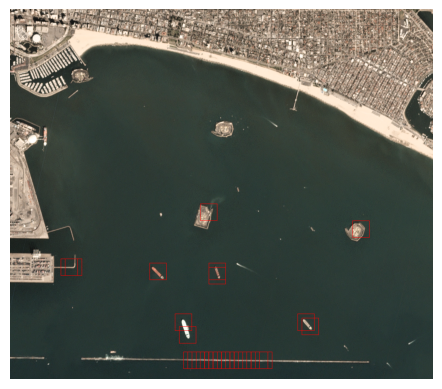

In [12]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_1.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model)

Prediction time: 3.29 seconds


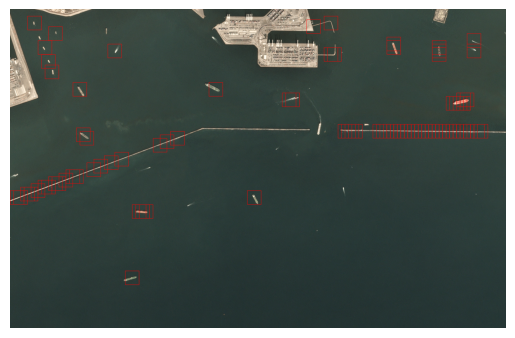

In [13]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_2.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model)

Prediction time: 2.00 seconds


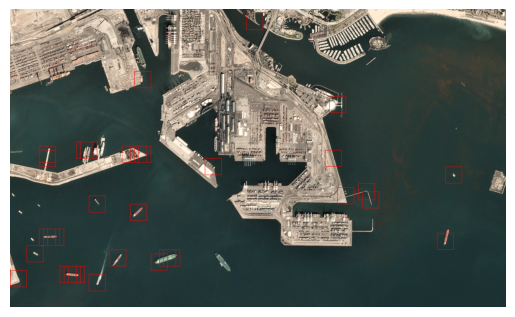

In [14]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_3.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model)

Prediction time: 2.21 seconds


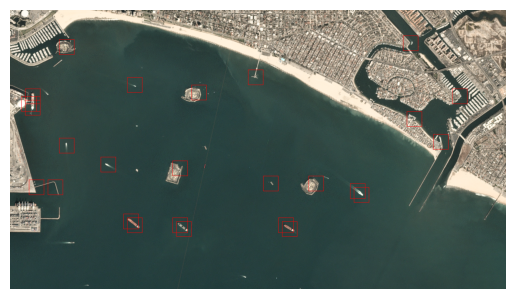

In [15]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_4.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model)

# Same model with Data Augmentation

In [16]:
import numpy as np

# Convert list of lists to NumPy array
X_array = transform(X)  # Shape: (num_samples, 80, 80, 3)
y_array = data_df['labels']  # Shape: (num_samples,)




## Augmenting Ship Images

In [17]:
# Filter 'ship' images
ship_images = X_array[y_array == 1]

ship_images.shape

(1000, 80, 80, 3)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define a custom function for 90 and 270-degree rotations
def custom_rotation(image):
    # Choose between no rotation (0), 90, or 270 degrees
    rotation_choices = [0, 90, 270]
    random_rotation = np.random.choice(rotation_choices)
    if random_rotation == 90:
        image = np.rot90(image)
    elif random_rotation == 270:
        image = np.rot90(image, k=3)
    return image

# Initialize the ImageDataGenerator with horizontal and vertical flips only
datagen_ship = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,  # Enable vertical flips
    preprocessing_function=custom_rotation  # Apply 90 or 270 degree rotation
)

In [19]:
augmented_images = []
num_augmented_per_image = 2  # Number of augmented images per original image

for image in ship_images:
    image = image.reshape((1,) + image.shape)  # Reshape for the generator
    count = 0  # Reset counter for each image
    for batch in datagen_ship.flow(image, batch_size=1):
        augmented_images.append(batch[0].astype('uint8'))
        count += 1
        if count >= num_augmented_per_image:
            break

augmented_images = np.array(augmented_images)

augmented_images.shape


(2000, 80, 80, 3)

In [20]:
# Update X and y
X_array = np.concatenate((X_array, augmented_images), axis=0)
y_array = np.concatenate((y_array, np.ones(len(augmented_images))), axis=0)  # Label 1 for 'ship'

X_array.shape

(6000, 80, 80, 3)

## Model and Testing 

In [21]:
# First we need to split the set into training and test

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, 
                                                    test_size=0.3,  # Adjust the test size as needed
                                                    random_state=43,  # For reproducibility
                                                    stratify=y_array)  # Ensures the proportion of classes is maintained





In [22]:
# Train model on augmented data

# Fit model

model_2 = initialize_model()

es = EarlyStopping(patience= 3, restore_best_weights=True)

model_2.fit(X_train, y_train,
          epochs=15, 
          batch_size=32,
          validation_split=0.2,
          callbacks=[es])

Epoch 1/15
105/105 [==============================] - 6s 47ms/step - loss: 0.2727 - accuracy: 0.8893 - recall_1: 0.8180 - precision_1: 0.9558 - val_loss: 0.1177 - val_accuracy: 0.9560 - val_recall_1: 0.9387 - val_precision_1: 0.9696
Epoch 2/15
105/105 [==============================] - 5s 45ms/step - loss: 0.1209 - accuracy: 0.9497 - recall_1: 0.9415 - precision_1: 0.9579 - val_loss: 0.1903 - val_accuracy: 0.9262 - val_recall_1: 0.8529 - val_precision_1: 0.9943
Epoch 3/15
105/105 [==============================] - 4s 42ms/step - loss: 0.1031 - accuracy: 0.9598 - recall_1: 0.9509 - precision_1: 0.9687 - val_loss: 0.0967 - val_accuracy: 0.9595 - val_recall_1: 0.9608 - val_precision_1: 0.9561
Epoch 4/15
105/105 [==============================] - 5s 43ms/step - loss: 0.1018 - accuracy: 0.9580 - recall_1: 0.9521 - precision_1: 0.9641 - val_loss: 0.1028 - val_accuracy: 0.9583 - val_recall_1: 0.9583 - val_precision_1: 0.9560
Epoch 5/15
105/105 [==============================] - 5s 43ms/step -

In [23]:
# Evaluate model

evaluation = model_2.evaluate(X_test, y_test)

evaluation

57/57 [==============================] - 0s 7ms/step - loss: 0.0851 - accuracy: 0.9700 - recall_1: 0.9722 - precision_1: 0.9679


[0.08511219173669815,
 0.9700000286102295,
 0.9722222089767456,
 0.9679203629493713]

Prediction time: 2.69 seconds


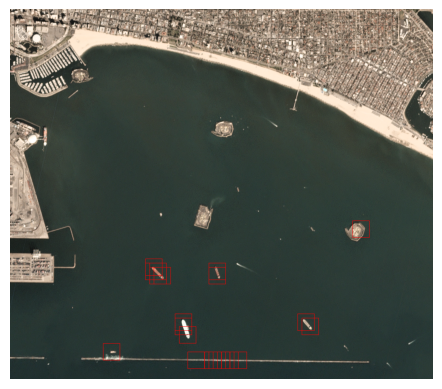

In [24]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_1.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model_2)


Prediction time: 4.12 seconds


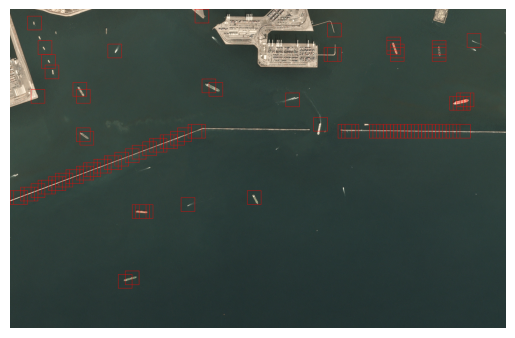

In [25]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_2.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model_2)

Prediction time: 2.18 seconds


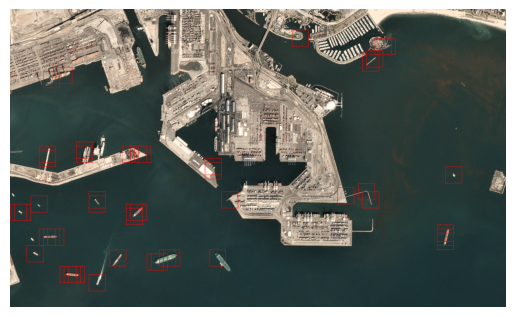

In [26]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_3.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model_2)

Prediction time: 2.20 seconds


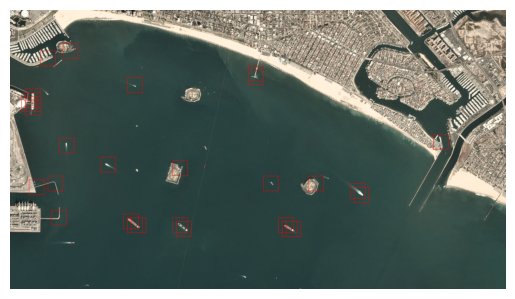

In [27]:
# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_4.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model(image, model_2)

# Approach with more complex model, train and test split 20% instead of 30%, and images in grayscale -> BEST MODEL

In [28]:
data_df = pd.DataFrame(data)



#define the feature and target
X= data['data']
y=data_df['labels']

In [29]:
# First we need to split the set into training and test

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,  # Adjust the test size as needed
                                                    random_state=43,  # For reproducibility
                                                    stratify=y)  # Ensures the proportion of classes is maintained

In [30]:
import numpy as np

# Function to convert RGB to grayscale, reshape, and normalize
def rgb_to_grayscale(X):
    X_gray = []
    for img in X:
        # Split the flattened list into R, G, and B channels
        R = np.array(img[:6400])
        G = np.array(img[6400:12800])
        B = np.array(img[12800:])
        
        # Convert to grayscale using the luminosity method: 0.2989*R + 0.5870*G + 0.1140*B
        gray_img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    
        
        # Reshape to (80, 80, 1)
        gray_img = gray_img.reshape(80, 80, 1)
        
        X_gray.append(gray_img)
    
    return np.array(X_gray)


In [31]:
# Apply the conversion to X_train and X_test
X_train_gray = rgb_to_grayscale(X_train)
X_test_gray = rgb_to_grayscale(X_test)

print(X_train_gray.shape)  # Should print (3200, 80, 80, 1)
print(X_test_gray.shape)   # Should print (800, 80, 80, 1)

(3200, 80, 80, 1)
(800, 80, 80, 1)


In [32]:
def initialize_model_2():
    model = Sequential()
    model.add(layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (80,80,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 128 , activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units = 1 , activation = 'sigmoid'))

  # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', Recall(), Precision()])
   
    
    return model

In [33]:
# Fit model

model_3 = initialize_model_2()

es = EarlyStopping(patience= 3, restore_best_weights=True)

model_3.fit(X_train_gray, y_train,
          epochs=15, 
          batch_size=32,
          validation_split=0.2,
          callbacks=[es])

Epoch 1/15
80/80 [==============================] - 20s 216ms/step - loss: 0.3417 - accuracy: 0.9027 - recall_2: 0.8082 - precision_2: 0.8019 - val_loss: 0.1666 - val_accuracy: 0.9516 - val_recall_2: 0.9146 - val_precision_2: 0.8982
Epoch 2/15
80/80 [==============================] - 17s 214ms/step - loss: 0.1421 - accuracy: 0.9523 - recall_2: 0.9135 - precision_2: 0.8966 - val_loss: 0.3654 - val_accuracy: 0.8422 - val_recall_2: 0.9939 - val_precision_2: 0.6198
Epoch 3/15
80/80 [==============================] - 18s 219ms/step - loss: 0.0903 - accuracy: 0.9754 - recall_2: 0.9497 - precision_2: 0.9512 - val_loss: 0.0925 - val_accuracy: 0.9594 - val_recall_2: 0.9390 - val_precision_2: 0.9059
Epoch 4/15
80/80 [==============================] - 17s 215ms/step - loss: 0.0905 - accuracy: 0.9777 - recall_2: 0.9607 - precision_2: 0.9502 - val_loss: 0.0604 - val_accuracy: 0.9797 - val_recall_2: 0.9573 - val_precision_2: 0.9632
Epoch 5/15
80/80 [==============================] - 17s 214ms/step -

In [34]:
# Evaluate model

evaluation = model_3.evaluate(X_test_gray, y_test)

evaluation

25/25 [==============================] - 1s 53ms/step - loss: 0.0330 - accuracy: 0.9925 - recall_2: 0.9850 - precision_2: 0.9850


[0.033006832003593445,
 0.9925000071525574,
 0.9850000143051147,
 0.9850000143051147]

In [35]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time

def generate_scene_with_model_gray_scale(image, model):
    # Define parameters
    patch_size = 80
    stride = 20

    # Create a copy of the image for drawing the red boxes
    output_image = image.copy()
    img_array = np.array(image)
    draw = ImageDraw.Draw(output_image)

    # Initialize variables
    img_height, img_width = img_array.shape[:2]
    patches = []
    coordinates = []

    # Extract patches and their coordinates
    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            sub_image = img_array[y:y+patch_size, x:x+patch_size]
            
            # Convert to grayscale (use Pillow's built-in method)
            gray_patch = Image.fromarray(sub_image).convert('L')
            
            # Convert the grayscale patch to numpy array and normalize
            gray_patch_array = np.array(gray_patch) 
            # Reshape to (80, 80, 1) to fit the model input
            gray_patch_array = gray_patch_array.reshape(80, 80, 1)
            
            patches.append(gray_patch_array)
            coordinates.append((x, y))

    # Convert patches to numpy array
    patches_array = np.array(patches)

    # Perform batch prediction
    start_time = time.time()
    predictions = model.predict(patches_array, verbose=0)
    print(f"Prediction time: {time.time() - start_time:.2f} seconds")

    # Draw rectangles for patches classified as containing a ship
    for idx, prediction in enumerate(predictions):
        if prediction[0] > 0.6:
            x, y = coordinates[idx]
            draw.rectangle([x, y, x + patch_size, y + patch_size], outline="red", width=2)

    # Display the output image with red boxes
    plt.imshow(output_image)
    plt.axis('off')  # Hide the axis
    plt.show()


Prediction time: 13.32 seconds


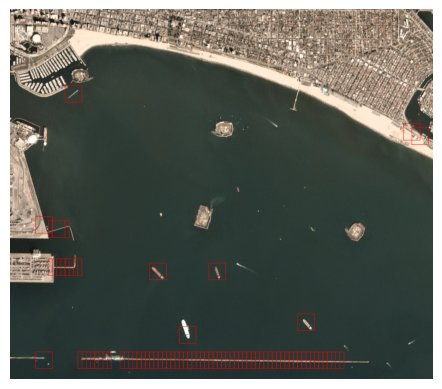

In [36]:


# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_1.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model_gray_scale(image, model_3)



Prediction time: 20.85 seconds


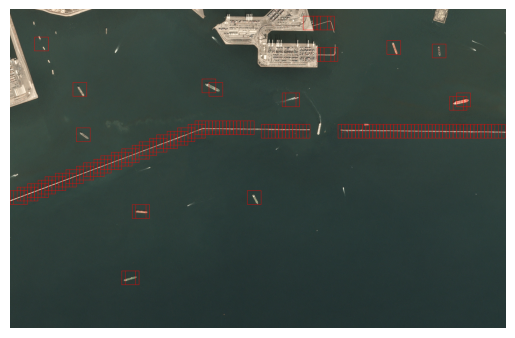

In [37]:


# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_2.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model_gray_scale(image, model_3)



Prediction time: 14.07 seconds


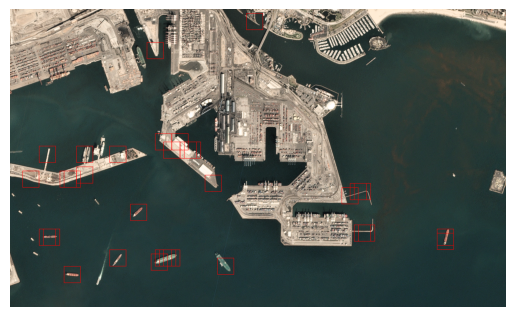

In [38]:


# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_3.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model_gray_scale(image, model_3)



Prediction time: 15.94 seconds


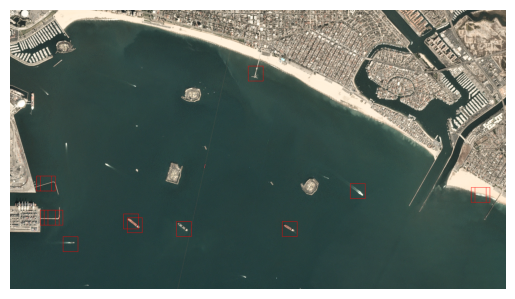

In [39]:


# Define the image path
image_path = "/Users/alexrohn/code/AlexRohn-96/shipvision_lewagon_backend/raw_data/scenes/lb_4.png"

# Load the image
image = Image.open(image_path)


generate_scene_with_model_gray_scale(image, model_3)

